# Day4 強化学習に対するニューラルネットワークの適用

## 初めに
`xvfb-run -s "-screen 0 1400x900x24" jupyter lab`でjupyter labを起動してください

## TODO: Tensorboardを使った可視化

## Policy Gradient

Deepの構造
* 3層のMLP
* Input: 状態, Output: 

In [1]:
#TensorFlowがGPUを認識しているか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-11-24 13:44:18.895864: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-11-24 13:44:18.934814: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-11-24 13:44:18.939347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55677ae06f60 executing computations on platform Host. Devices:
2022-11-24 13:44:18.939384: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-11-24 13:44:18.941488: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-11-24 13:44:19.379003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55677d157750 executing computations on platform CUDA. Devices:
2022-11-24 13:44:19.379038: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Tesla V100-PC

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7614301413788005229,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4644825238985385370
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8356085742436174938
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7616011449508387215
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15506083943935423730
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13075022150512524086
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
# import tensorflow as tf
# config = tf.ConfigProto(
#     gpu_options=tf.GPUOptions(
#         visible_device_list="3", # specify GPU number
#         allow_growth=True
#     )
# )
# sess = tf.Session(config=config)

↑設定できない、ナニコレ

In [3]:
import os
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.python import keras as K
import gym
import sys
sys.path.append("../FN")
from fn_framework import FNAgent, Trainer, Observer, Experience
tf.compat.v1.disable_eager_execution()

/home/kenta_suzuki/miniconda3/envs/rl-book/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


code4-20 agent定義

In [4]:
class PolicyGradientAgent(FNAgent):

    def __init__(self, actions):
        # PolicyGradientAgent uses self policy (doesn't use eplision).
        # 全て戦略に基づいて行動する (本当か？ epsilon=0にしただけだと、initialized=Falseの時にランダムに行動しない？)
        # initializedがTrueになるタイミングは？ -> loadの時, initialize()が走った時
        # episode_endの時にinitialize呼ばれる -> 最初のtrain_loopではinitializeがFalseのままでは?
        super().__init__(epsilon=0.0, actions=actions)
        self.estimate_probs = True
        self.scaler = StandardScaler()
        self._updater = None # パラメータ更新関数は後ほど定義するため、一旦None

    # 学習モデル保存
    def save(self, model_path):
        super().save(model_path)
        joblib.dump(self.scaler, self.scaler_path(model_path))

    # agentの読み込み
    @classmethod
    def load(cls, env, model_path):
        actions = list(range(env.action_space.n))

        agent = cls(actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        agent.scaler = joblib.load(agent.scaler_path(model_path))
        return agent

    def scaler_path(self, model_path):
        fname, _ = os.path.splitext(model_path)
        fname += "_scaler.pkl"
        return fname

    # モデルの定義
    def initialize(self, experiences, optimizer):
        states = np.vstack([e.s for e in experiences])
        feature_size = states.shape[1]
        self.model = K.models.Sequential([
            K.layers.Dense(10, activation="relu", input_shape=(feature_size,)),
            K.layers.Dense(10, activation="relu"),
            K.layers.Dense(len(self.actions), activation="softmax")
        ])
        self.set_updater(optimizer)
        self.scaler.fit(states)
        self.initialized = True
        print("Done initialization. From now, begin trainning!")

    # original lossの定義とパラメータ更新
    # 図4-28参照
    def set_updater(self, optimizer):
        # pi_θ(a|s)の計算
        actions = tf.compat.v1.placeholder(shape=(None), dtype="int32")
        rewards = tf.compat.v1.placeholder(shape=(None), dtype="float32")
        one_hot_actions = tf.one_hot(actions, len(self.actions), axis=1)
        action_probs = self.model.output
        selected_action_probs = tf.reduce_sum(one_hot_actions * action_probs, axis=1)

        # log(pi_θ(a|s)) * Q(s, a)の計算
        # 0だとlog値が計算できないので、値を制限
        clipped = tf.clip_by_value(selected_action_probs, 1e-10, 1.0)
        loss = - tf.math.log(clipped) * rewards
        loss = tf.reduce_mean(loss)
        # ▽の計算
        updates = optimizer.get_updates(loss=loss, params=self.model.trainable_weights)
        self._updater = K.backend.function(inputs=[self.model.input, actions, rewards],
                                           outputs=[loss],
                                           updates=updates)

    def estimate(self, s):
        normalized = self.scaler.transform(s)
        # dqnの時とは違い、各行動に対する確率が出力される
        action_probs = self.model.predict(normalized)[0]
        return action_probs

    def update(self, states, actions, rewards):
        normalizeds = self.scaler.transform(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        self._updater([normalizeds, actions, rewards])

     # jupyter labで描画させるためにoverlap
    def play(self, env, episode_count=1, render=True):
        action_dic = {0: "left", 1: "right"}
        for e in range(episode_count):
            s = env.reset()
            done = False
            episode_reward = 0
            cnt = 0
            get_num = 0
            play_num = 1
            while not done:
                # 毎回レンダリングすると遅くなるので最初の50回は毎回レンダリングし、その後は50回おきにする
                if render and (cnt % 5 == 0):
                    env.render()
                a = self.policy(s)
                n_state, reward, done, info = env.step(a)
                plt.title(f"episode={e}, action={action_dic[a]}, done={done}, frame={cnt}")
                episode_reward += reward
                s = n_state
                cnt += 1
            else:
                print("Get reward {}.".format(episode_reward))

code4-21 CartPole用のobserver定義

In [5]:
class CartPoleObserver(Observer):

    def transform(self, state):
        return np.array(state).reshape((1, -1))

    # jupyter labで描画させるためにoverlap
    def render(self):
        # self._env.render(mode="rgb_array")
        plt.imshow(self._env.render(mode="rgb_array"))
        display.display(plt.gcf())
        display.clear_output(wait=True)

code4-22 Trainerの定義

In [6]:
class PolicyGradientTrainer(Trainer):

    def __init__(self, buffer_size=256, batch_size=32, gamma=0.9, report_interval=10, log_dir=""):
        super().__init__(buffer_size, batch_size, gamma, report_interval, log_dir)

    def train(self, env, episode_count=220, initial_count=-1, render=False):
        actions = list(range(env.action_space.n))
        agent = PolicyGradientAgent(actions)
        self.train_loop(env, agent, episode_count, initial_count, render)
        return agent

    def episode_begin(self, episode, agent):
        if agent.initialized:
            self.experiences = []

    def make_batch(self, policy_experiences):
        length = min(self.batch_size, len(policy_experiences))
        batch = random.sample(policy_experiences, length)
        states = np.vstack([e.s for e in batch])
        actions = [e.a for e in batch]
        rewards = [e.r for e in batch]
        scaler = StandardScaler()
        rewards = np.array(rewards).reshape((-1, 1))
        rewards = scaler.fit_transform(rewards).flatten()
        return states, actions, rewards

    # 価値の更新
    # モデルが学習するのはここ
    def episode_end(self, episode, step_count, agent):
        rewards = [e.r for e in self.get_recent(step_count)]
        self.reward_log.append(sum(rewards))

        if not agent.initialized:
            if len(self.experiences) == self.buffer_size:
                optimizer = K.optimizers.Adam(lr=0.01)
                agent.initialize(self.experiences, optimizer)
                self.training = True
        else:
            # 価値更新
            policy_experiences = []
            for t, e in enumerate(self.experiences):
                s, a, r, n_s, d = e
                # 割引現在価値: gammaで割り引く
                d_r = [_r * (self.gamma ** i) for i, _r in enumerate(rewards[t:])]
                d_r = sum(d_r)
                d_e = Experience(s, a, d_r, n_s, d)
                policy_experiences.append(d_e)

            agent.update(*self.make_batch(policy_experiences))

        if self.is_event(episode, self.report_interval):
            recent_rewards = self.reward_log[-self.report_interval:]
            self.logger.describe("reward", recent_rewards, episode=episode)

code4-23

In [7]:
def main(play):
    env = CartPoleObserver(gym.make("CartPole-v0"))
    trainer = PolicyGradientTrainer()
    path = trainer.logger.path_of("policy_gradient_agent.h5")

    if play:
        agent = PolicyGradientAgent.load(env, path)
        agent.play(env)
    else:
        trained = trainer.train(env)
        trainer.logger.plot("Rewards", trainer.reward_log,
                            trainer.report_interval)
        trained.save(path)

cnn使ってないので、学習は比較的早い（がかなり初期値によってばらつく、学習期間が短い or MLPの限界?）

Get reward 89.0.


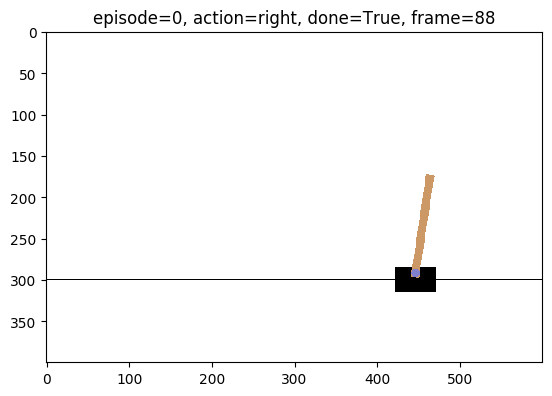

In [8]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="PG Agent")
    parser.add_argument("--play", action="store_true",
                        help="play with trained model")
    # args=[]で学習, args=["--play"]で学習したモデルで遊べる
    args = parser.parse_args(args=["--play"])
    main(args.play)
